In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from utils import HousePriceData, TestingData
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [95]:
pca_list = list(range(1,68))

In [96]:
replace_by = [
    "Z", 
    "NA",
    "None",          #Can be changed to NonewNA
    "Z",             #Can be changed to ZwM
    "NA",
    "NA",
    "NA",            #Includes option "No" but mean different thing
    "NA",
    "NA",
    "SBrkr",            #Electrical, only 1 NA
    "NA",
    "NA",
    "Z",             #Can be changed to Z
    "NA",
    "NA",
    "NA",
    "NA",
    "NA",
    "NA"
    ]



In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [98]:
import warnings
warnings.filterwarnings('ignore')

train_score = []
test_score = []
correlation_thresholds = [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45]
for corr in tqdm(correlation_thresholds):
    x_scaler = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ])
    output_scaler = StandardScaler()

    data = HousePriceData("dataset/train.csv", x_scaler, output_scaler)
    null_cols = data.check_na(print_null_cols=False)
    data.clean_data(null_cols, replace_by)

    mapping = data.convert_to_categorical()

    data.get_dataframe()

    output_column = 'SalePrice'

    # Calculate correlation coefficients between all columns and the output column
    correlations = data.get_dataframe().corr(method="pearson")[output_column]

    # Filter columns based on the specified range
    selected_columns = correlations[(correlations <= corr) & (correlations >= -corr)].index.tolist()
    for column in selected_columns:
        data.drop_column(column)
    
    data.fit_preprocessors()

    X_train, X_test, y_train, y_test = data.get_train_test_split()
    classifier = SVR()

    classifier.fit(X_train, y_train)
    train_score.append(classifier.score(X_train, y_train))
    test_score.append(classifier.score(X_test, y_test))




100%|██████████| 12/12 [00:18<00:00,  1.56s/it]


In [99]:
import matplotlib.pyplot as plt

In [100]:
train_score

[0.8726208695923013,
 0.8740856003160313,
 0.8753619785264073,
 0.8742873388417787,
 0.8799561083576248,
 0.8929253431961661,
 0.8963679252369703,
 0.9011120147788396,
 0.8873450726841479,
 0.8870801900506967,
 0.8837696814940429,
 0.8811033855414622]

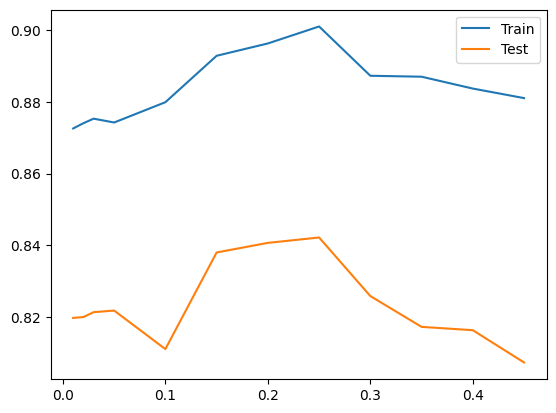

In [101]:
plt.plot(correlation_thresholds, train_score, label="Train")
plt.plot(correlation_thresholds, test_score, label = "Test")
plt.legend()
plt.show()